# Imports

In [63]:
import pandas as pd
import itertools as it
import plotly.express as px
from datasets import Dataset
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE
import plotly.graph_objects as go
pd.options.plotting.backend = "plotly"
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from sklearn.metrics import accuracy_score, f1_score
from urllib.request import urlopen
from sklearn.cluster import KMeans

# EDA

## Utils

In [2]:
label_to_name = {
    'minus_m': 'Negatywny',
    'zero': 'Neutralny',
    'plus_m': 'Pozytywny',
    'amb': 'Niejednoznaczny',
    'minus_s': 'Lekko Negatywny',
    'plus_s': 'Lekko Pozytywny',
}

def preprocess_dataset(dataset_path: str) -> pd.DataFrame:
    texts = []
    labels = []
    with open(dataset_path, 'r', encoding='utf-8') as f:
        for line in f:
            if '__label__z_' in line:
                text, label = line.split('__label__z_')
                texts.append(text)
                label = label_to_name.get(label.strip(), 'Nieznany')
                labels.append(label.strip())
    return pd.DataFrame({'text': texts, 'label': labels})

            

## Wczytywanie zbiorów

In [3]:
train_path = 'dataset_clarin/dataset/all2.sentence.train.txt'
val_path = 'dataset_clarin/dataset/all2.sentence.dev.txt'
test_path = 'dataset_clarin/dataset/all2.sentence.test.txt'

train_df = preprocess_dataset(train_path)
val_df = preprocess_dataset(val_path)
test_df = preprocess_dataset(test_path)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)


## Dystrybucja klas

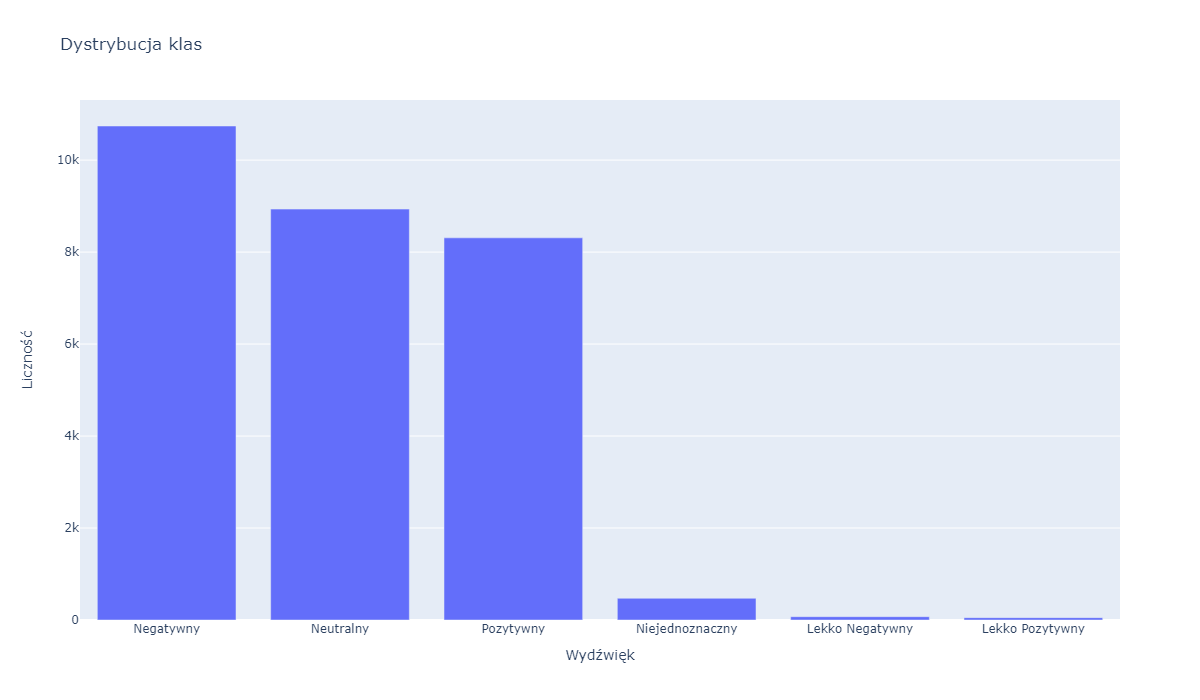

In [89]:
fig = train_df['label'].value_counts().plot(kind='bar', title='Dystrybucja klas', labels={'index': 'Wydźwięk', 'value': 'Liczność'})
fig.update_layout(showlegend=False, width=1200, height=700)
fig.show()

Dataset jest niezbalansowany, a ilość wystąpień w najrzadszych klasach nie pozwala na zastosowanie undersamplingu ani oversamplingu. Z tego powodu zdecydowano się na zastosowanie metryki F1, która jest mniej wrażliwa na niezbalansowanie klas.

# Długość zdań

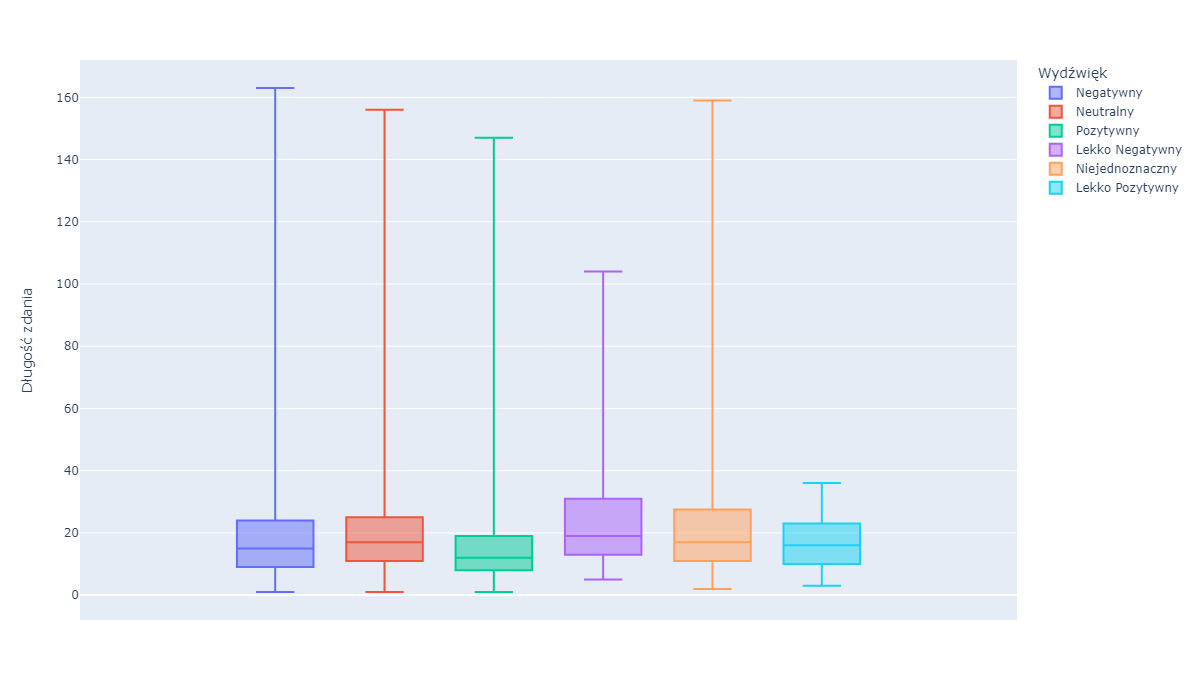

In [178]:
train_df['sentence_length'] = train_df['text'].apply(lambda x: len(x.split()))
px.box(train_df, y='sentence_length', color='label', points=False, labels={'sentence_length': 'Długość zdania', 'label': 'Wydźwięk'}, width=1200, height=700)

Nie ma istotnych różnic w długościach zdań pomiędzy klasami.

## Najczęstsze słowa

In [50]:
# Zebranie wszystkich słow i usunięcie stopwords
all_words = list(it.chain.from_iterable(train_df['text'].apply(lambda x: x.split()).values))
stopwords = urlopen('https://raw.githubusercontent.com/bieli/stopwords/master/polish.stopwords.txt').read().decode('utf-8').split('\n')
all_words = list(filter(lambda x: len(x) > 3 and x not in stopwords, all_words))

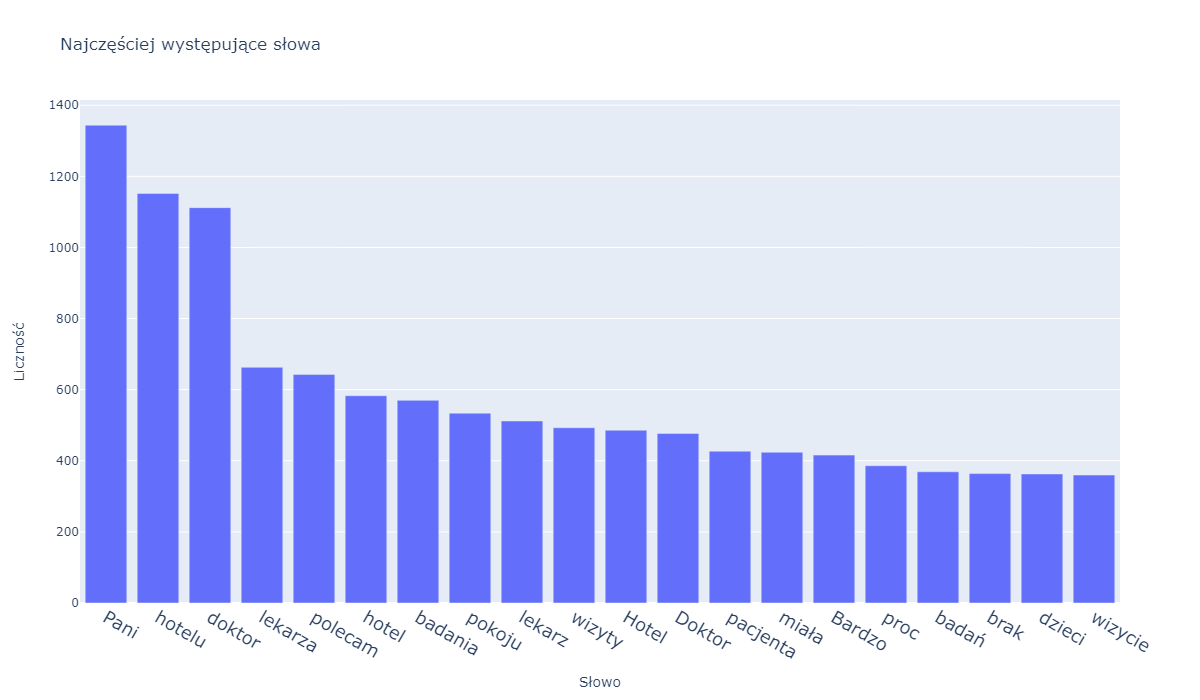

In [99]:
fig = pd.Series(all_words).value_counts()[0:20].plot(kind='bar', title='Najczęściej występujące słowa', labels={'index': 'Słowo', 'value': 'Liczność'})
fig.update_layout(showlegend=False, width=1200, height=700, xaxis_tickfont=dict(size=18))
fig

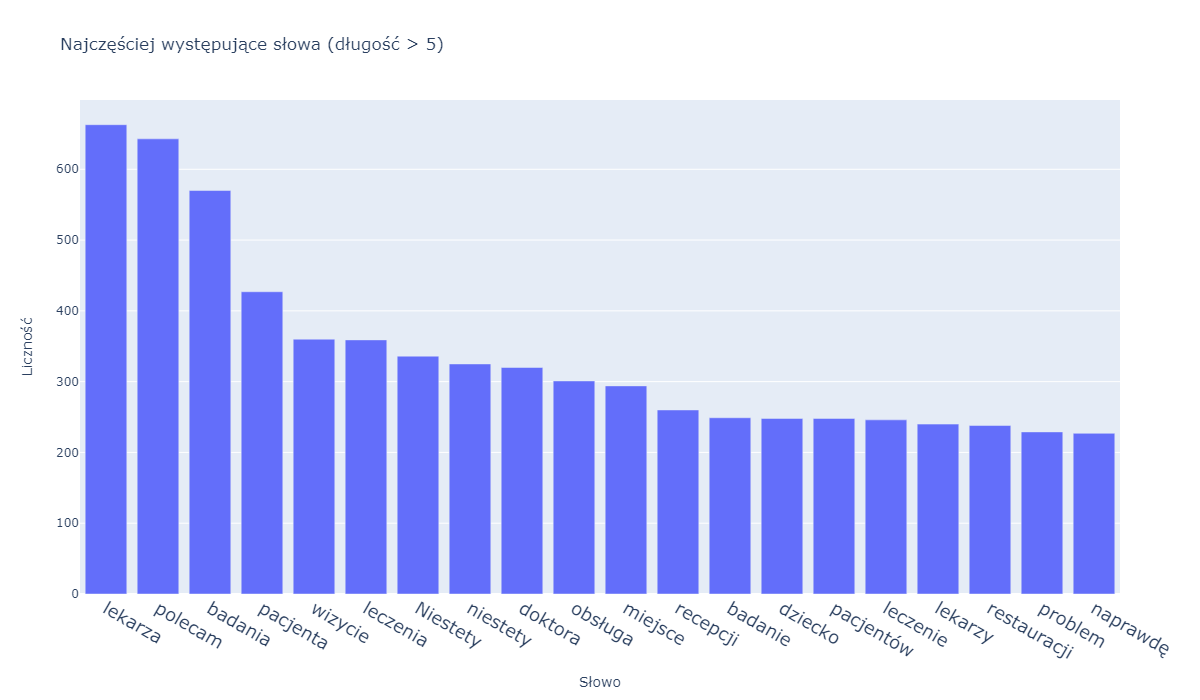

In [100]:
words_over_5 = list(filter(lambda x: len(x) > 6, all_words))
fig = pd.Series(words_over_5).value_counts()[0:20].plot(kind='bar', title='Najczęściej występujące słowa (długość > 5)', labels={'index': 'Słowo', 'value': 'Liczność'})
fig.update_layout(showlegend=False, width=1200, height=700, xaxis_tickfont=dict(size=18))
fig

# Modelowanie

## Embeddingi z BERTa

In [101]:
checkpoint  = 'sdadas/polish-distilroberta'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = AutoModel.from_pretrained(checkpoint).to(device)




cuda


Some weights of the model checkpoint at sdadas/polish-distilroberta were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at sdadas/polish-distilroberta and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [102]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, return_tensors='pt')

def add_embeddings(batch):
    with torch.no_grad():
        inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
        output = model(**inputs)
        batch['embeddings'] = output.last_hidden_state[:, 0].cpu().numpy()
    return batch


In [104]:
# tokenizacja zbiorów
encoded_train = train_dataset.map(tokenize, batched=True, batch_size=None)
encoded_train.set_format(type='torch', columns=['input_ids', 'attention_mask'])
encoded_test = test_dataset.map(tokenize, batched=True, batch_size=None)
encoded_test.set_format(type='torch', columns=['input_ids', 'attention_mask'])
encoded_val = val_dataset.map(tokenize, batched=True, batch_size=None)
encoded_val.set_format(type='torch', columns=['input_ids', 'attention_mask'])

Map:   0%|          | 0/28582 [00:00<?, ? examples/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [159]:
def get_sample_tsne_plot(label: str, sample_size: int = 1000):
    sample = encoded_train.filter(lambda x: x['label'] == label).shuffle().select(range(sample_size))
    sample = sample.map(add_embeddings, batched=True, batch_size=100)
    sample.set_format(type='torch', columns=['embeddings'])
    tsne = TSNE(n_components=2, random_state=42)
    tsne_embeddings = tsne.fit_transform(sample['embeddings'])
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], mode='markers', opacity=0.5, marker=dict(color='green')))
    fig.add_trace(go.Histogram2d(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1],  coloraxis= 'coloraxis'))
    return fig

In [160]:
# Wczytywanie wykresów
fig_positive = get_sample_tsne_plot('Pozytywny')
fig_neutral = get_sample_tsne_plot('Neutralny')
fig_negative = get_sample_tsne_plot('Negatywny')


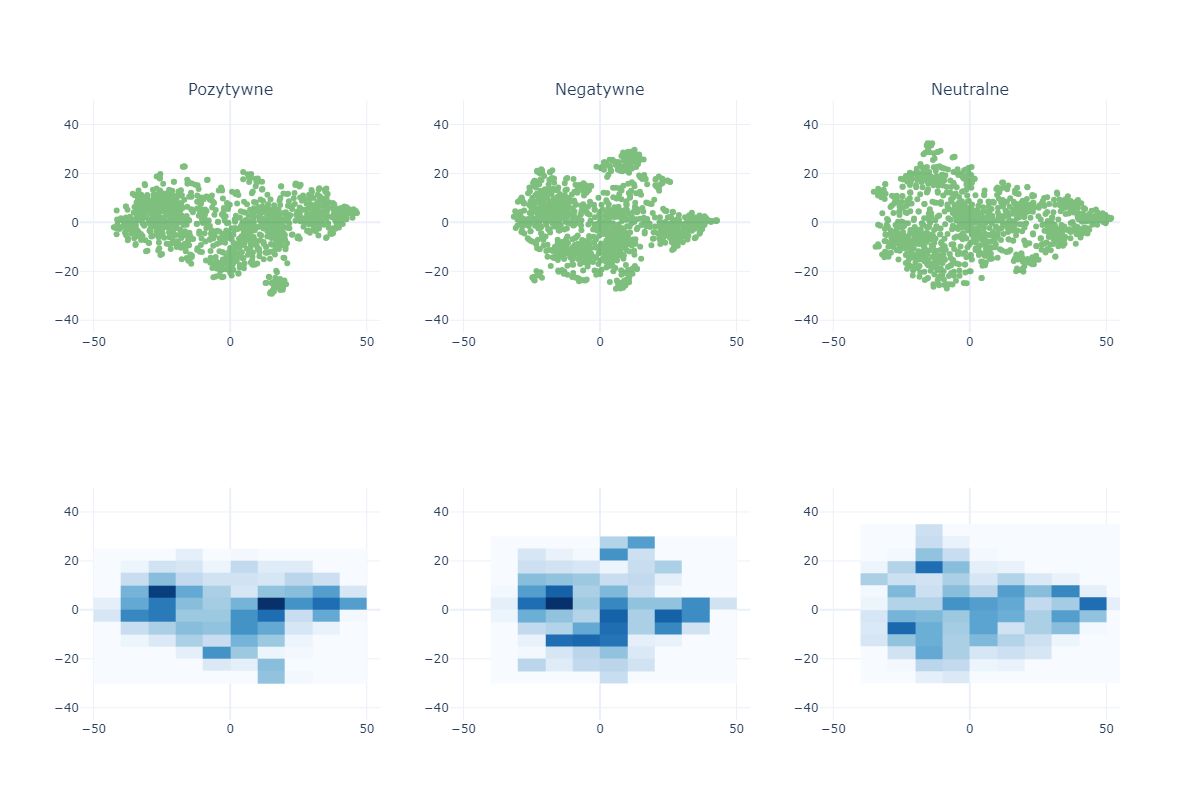

In [166]:

from plotly.subplots import make_subplots
fig = make_subplots(rows=2, cols=3, subplot_titles=('Pozytywne', 'Negatywne', 'Neutralne'))
for i, fig_ in enumerate((fig_positive, fig_negative, fig_neutral)):
    fig.add_trace(fig_.data[0], row=1, col= i + 1)
    fig.add_trace(fig_.data[1], row=2, col= i + 1)
fig.update_layout(height=800, width=1200, showlegend=False, coloraxis=dict(colorscale='Blues', showscale=False), template='plotly_white')
fig.update_xaxes(range=[-55, 55])
fig.update_yaxes(range=[-45, 50])
fig.show()

Pomimo różnic między klasami, przy rzutowaniu embeddingów na 2 wymiary, klastry nie są łatwo separowalne. Jednak nie oznacza to że nie są separowalne w wyższych wymiarach 

# Clustering

In [83]:

sample = encoded_train.shuffle().select(range(100))
sample = sample.map(add_embeddings, batched=True, batch_size=10)
sample.set_format(type='torch', columns=['embeddings'])
tsne = TSNE(n_components=3, random_state=42)
tsne_embeddings = tsne.fit_transform(sample['embeddings'])
kmeans = KMeans(n_clusters=2, random_state=42).fit(tsne_embeddings)
labels = kmeans.labels_

sample = sample.add_column('topic', labels)


c:\Users\pance\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [179]:
cluster_0 = sample.filter(lambda x: x['topic'] == 0)
cluster_1 = sample.filter(lambda x: x['topic'] == 1)

print("Klaster 1")
print(*cluster_0['text'][:10], sep='\n')
print("-----------------")
print("Klaster 2")
print(*cluster_1['text'][:10], sep='\n')



Klaster 1
Usytuowanie złe : hałas od Warszawskiej , daleko do Malty . 
Weszli śmy - wszystkie stoliki zajęte - okazało się , że nikogo za bardzo to nie interesuje , że chcemy zarezerwować najbliższy wolny stolik - trzeba było walczyć o miejsce - czyli zwisać nad jedzącymi natarczywie upatrując pustych talerzy - nie było to zbyt miłe , ani dla nas , ani dla " konsumujących " - obsługa nie wykazała zainteresowania , by jakoś to usprawnić . 
Podczas dokonywania zakupu bardzo sugerowała m się informacją , że w hotelu jest basen , co wynikało by ze zdjęć zamieszczonych na stronie internetowej i podpisanych ‚ Villa Lessing ‘ . 
Wchodząc do gabinetu usłyszała m , że jestem spóźniona i ona nie ma zamiaru mnie przyjąć , bo " Nie będzie przecież cały dzień tutaj siedziała " Z takim traktowaniem nie spotkała m się nawet w publicznej służbie zdrowia . 
Jak można się domyślac , Niemców lokuje się w budynku głównym ( tym z obrazka w katalogu ) W korytarzu na sofach - pluskwy , zatem widac kto pierws

Uzyskane klastry, prawdopodobnie ze względu na wiele możliwości podziału zbioru, zdają się nie reprezentowac niczego szczególnego

# Finetuning

In [170]:
batch_size = 64

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    return {'accuracy': acc, 'f1': f1}



checkpoint  = 'sdadas/polish-distilroberta'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=6).to(device)
model = AutoModelForSequenceClassification.from_pretrained('./results/distilbert1/model', num_labels=6).to(device)

label_to_id = {
    'Negatywny': 0,
    'Neutralny': 1,
    'Pozytywny': 2,
    'Niejednoznaczny': 3,
    'Lekko Negatywny': 4,
    'Lekko Pozytywny': 5,
}

# Convert the labels to their corresponding integer values
encoded_train = encoded_train.map(lambda batch: {'labels': label_to_id[batch['label']]})
encoded_val = encoded_val.map(lambda batch: {'labels': label_to_id[batch['label']]})
encoded_test = encoded_test.map(lambda batch: {'labels': label_to_id[batch['label']]})

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    label_names=['labels'],
    
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)


In [ ]:
trainer.train()

In [172]:
trainer.evaluate()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████| 56/56 [00:12<00:00,  4.32it/s]


{'eval_loss': 0.4491543173789978,
 'eval_accuracy': 0.8527847746991324,
 'eval_f1': 0.43113190361588805,
 'eval_runtime': 13.5262,
 'eval_samples_per_second': 264.154,
 'eval_steps_per_second': 4.14}

In [173]:
def plot_confusion_matrix(predictions, true_values, labels):
    matrix = np.zeros((len(labels), len(labels)))
    for pred, true in zip(predictions, true_values):
        matrix[pred, true] += 1
    fig = go.Figure(data=go.Heatmap(
        z=matrix,
        x=labels,
        y=labels,
        colorscale='Blues',
        hoverongaps = False))
    fig.update_layout(title='Macierz pomyłek', xaxis_title='Prawdziwa klasa', yaxis_title='Przewidziana klasa', width=800, height=800)
    return fig

In [174]:

preds = trainer.predict(encoded_test).predictions.argmax(-1)
true_vals = encoded_test['labels']
labels = list(label_to_id.keys())


100%|██████████| 56/56 [00:15<00:00,  3.56it/s]


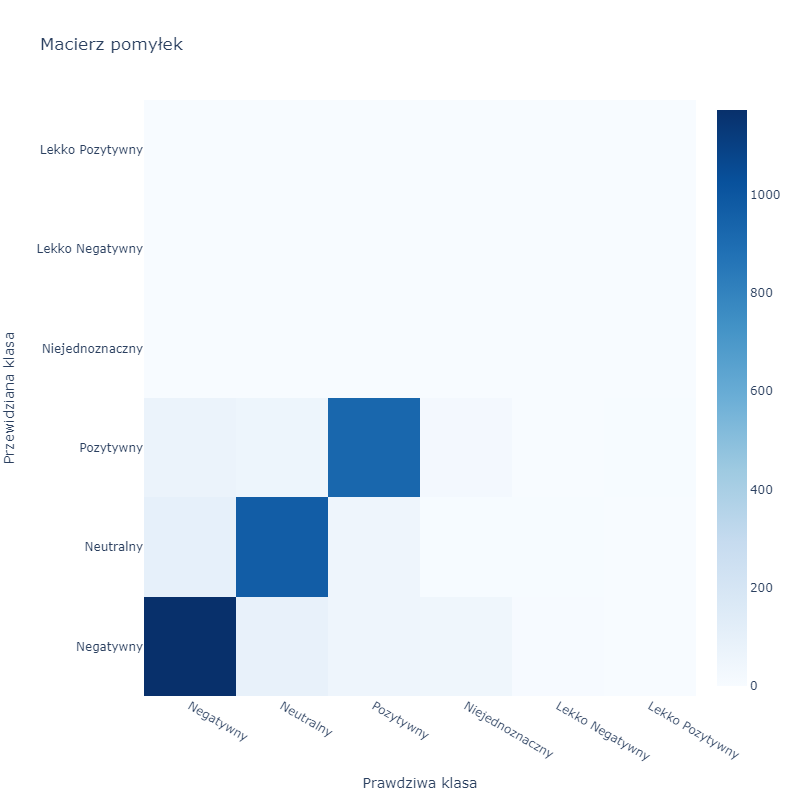

In [175]:
plot_confusion_matrix(preds, true_vals, labels)

## Bez rzadkich klas

In [176]:
test_no_minor_classes = encoded_test.filter(lambda x: x['labels'] not in (3, 4, 5))
preds = trainer.predict(test_no_minor_classes).predictions.argmax(-1)
true_vals = test_no_minor_classes['labels']
labels = ['Negatywny', 'Neutralny', 'Pozytywny']

100%|██████████| 55/55 [00:16<00:00,  3.41it/s]                      


In [19]:
trainer.evaluate(test_no_minor_classes)

100%|██████████| 55/55 [00:15<00:00,  3.66it/s]


{'eval_loss': 0.34947091341018677,
 'eval_accuracy': 0.8797704447632712,
 'eval_f1': 0.8797500178440978,
 'eval_runtime': 15.8453,
 'eval_samples_per_second': 219.938,
 'eval_steps_per_second': 3.471}

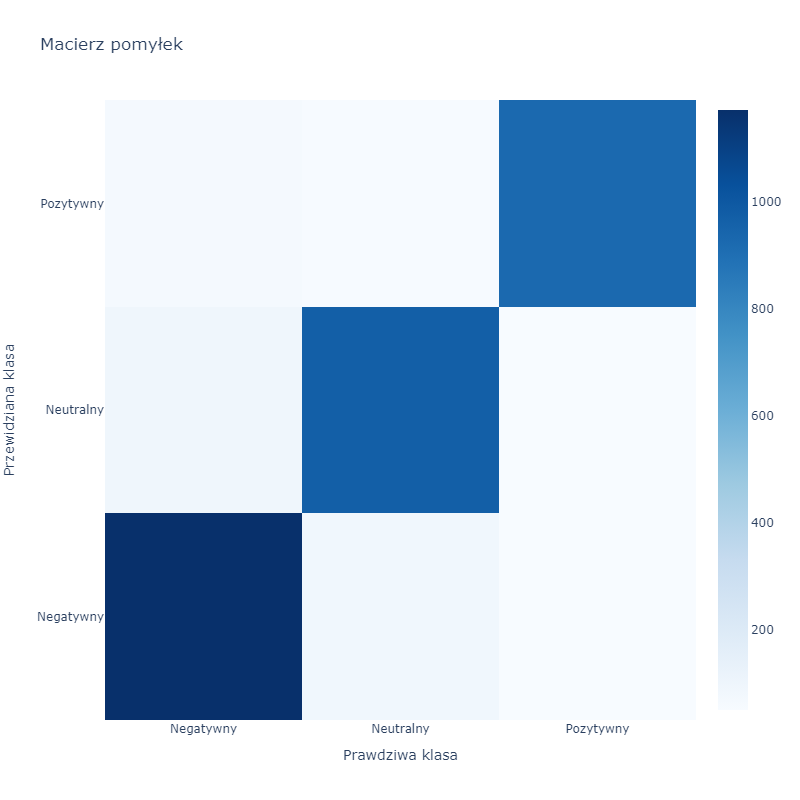

In [177]:
plot_confusion_matrix(preds, true_vals, labels)

## Trening bez rzadkich klas

In [14]:
batch_size = 64

checkpoint  = 'sdadas/polish-distilroberta'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=6).to(device)
# model = AutoModelForSequenceClassification.from_pretrained('./results/distilbert1/model', num_labels=6).to(device)

label_to_id = {
    'Negatywny': 0,
    'Neutralny': 1,
    'Pozytywny': 2,
    'Niejednoznaczny': 3,
    'Lekko Negatywny': 4,
    'Lekko Pozytywny': 5,
}

# Convert the labels to their corresponding integer values
encoded_train = encoded_train.filter(lambda x: x['labels'] not in (3, 4, 5))
encoded_val = encoded_val.filter(lambda x: x['labels'] not in (3, 4, 5))
encoded_test = encoded_test.filter(lambda x: x['labels'] not in (3, 4, 5))

training_args = TrainingArguments(
    output_dir='./results/distilbert_nominor/',
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    label_names=['labels'],
    
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

Some weights of the model checkpoint at sdadas/polish-distilroberta were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at sdadas/polish-distilroberta and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classif

In [ ]:
trainer.train()

In [16]:
trainer.evaluate(encoded_test)

100%|██████████| 55/55 [00:15<00:00,  3.62it/s]


{'eval_loss': 0.3151785135269165,
 'eval_accuracy': 0.8955523672883787,
 'eval_f1': 0.8953000106325403,
 'eval_runtime': 16.0349,
 'eval_samples_per_second': 217.339,
 'eval_steps_per_second': 3.43,
 'epoch': 3.0}

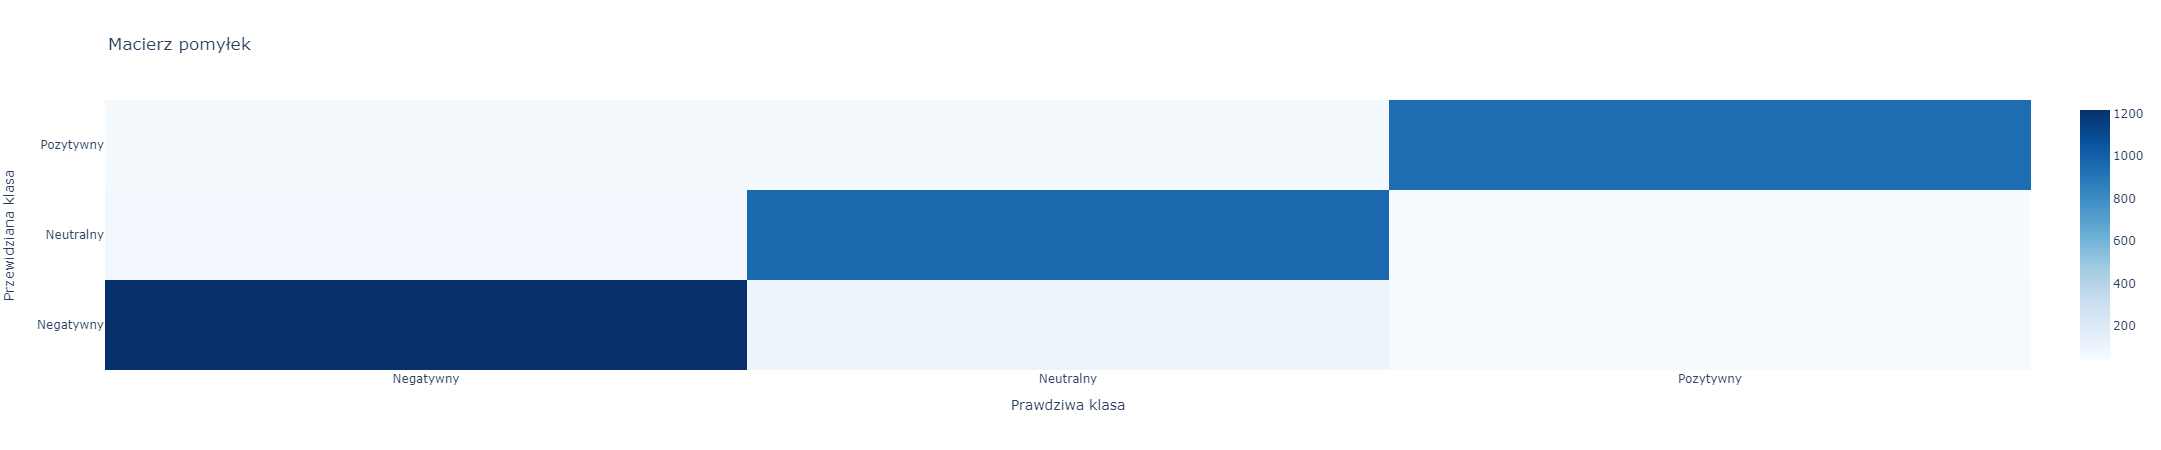

In [18]:

preds = trainer.predict(encoded_test).predictions.argmax(-1)
true_vals = encoded_test['labels']
labels = ['Negatywny', 'Neutralny', 'Pozytywny']

plot_confusion_matrix(preds, true_vals, labels)